In [40]:
chunk_size = '512'

generator = 'gpt-4.1'

embedder = 'text-embedding-3-large'

filename = embedder + '_' + generator + '_' + chunk_size

experiment = '_3'
GROLTS_LABELS = True
GROUND_TRUTH_PLOT = False

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import numpy as np
import re

pd.set_option('future.no_silent_downcasting', True)

path = './outputs/'

In [7]:
# Function to replace sentences containing 'yes' or 'no' with 1 or 0
def replace_yes_no(sentence):
    if isinstance(sentence, str):  # Check if the value is a string
        if re.search(r'\b(yes)\b', sentence, re.IGNORECASE):
            return 1
        elif re.search(r'\b(no)\b', sentence, re.IGNORECASE):
            return 0
    return sentence 

# Single Eval

703
703
Summed Acc:  14.351351351351353


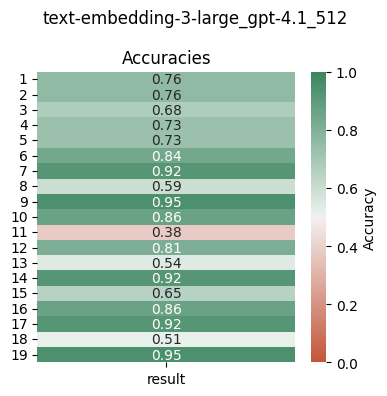

In [41]:
# Read the data
df = pd.read_csv(path + filename + experiment + '.csv')
df_labels = pd.read_csv('./human_labels.csv', delimiter=';', dtype=int)
df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
df_labels['paper_id'] = df_labels['paper_id'].astype(int)
df_labels['question_id'] = df_labels['question_id'].astype(int)
df_labels['answer'] = df_labels['answer'].astype(int)

# Replace 'YES'/'NO' answers with 1/0 in both DataFrames
#df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)
df['answer'] = df['answer'].apply(replace_yes_no)

# Merge the prediction and label DataFrames on 'paper_id' and 'question_id'
df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))

# Add a 'result' column indicating whether the prediction matches the true label
df_merged['result'] = np.where(
    df_merged['answer_pred'].isin([0, 1]),
    df_merged['answer_pred'] == df_merged['answer_true'],
    np.nan
)
print(len(df_merged))
df_nan = df_merged[df_merged.isna().any(axis=1)]
for row in df_nan.iterrows():
    print(row)
df_merged.dropna(inplace=True)
print(len(df_merged))

# Group by 'question_id' to calculate the mean accuracy per question
percent_true_by_question = df_merged.groupby('question_id')['result'].mean().reset_index()

# Print the summed accuracy
print('Summed Acc: ', percent_true_by_question['result'].sum())

# Plotting
if GROUND_TRUTH_PLOT:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
else:
    fig, ax1 = plt.subplots(figsize=(4, 4))

# Heatmap for predicted results
g = sns.heatmap(
    percent_true_by_question.set_index('question_id'),
    annot=True,
    cmap=sns.diverging_palette(20, 145, as_cmap=True),
    cbar_kws={'label': 'Accuracy'},
    vmin=0, vmax=1, ax=ax1
)
g.set_title('Accuracies')
g.set_xlabel('')
g.set_ylabel('')
if GROLTS_LABELS:
    g.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']) 
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

if GROUND_TRUTH_PLOT:
    percent_true_by_question_lab = df_labels.groupby('question_id')['answer'].mean().reset_index()
    percent_true_by_question_lab = percent_true_by_question_lab.reindex(percent_true_by_question.index)
    
    # Heatmap for ground truth results
    g = sns.heatmap(
        percent_true_by_question_lab.set_index('question_id'),
        annot=True,
        cmap=sns.diverging_palette(0, 0, l=100, center="dark", as_cmap=True),
        cbar_kws={'label': 'Accuracy'},
        vmin=0, vmax=1, ax=ax2
    )
    g.set_title('Ground Truth Mean')
    g.set_xlabel('')
    g.set_ylabel('')
    if GROLTS_LABELS:
        g.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']) 
    ax2.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Final plot adjustments
fig.suptitle(filename)
fig.tight_layout()
plt.savefig('../viz/' + filename + '.pdf', bbox_inches='tight')
plt.show()

# PDF merger

In [ ]:
from pypdf import PdfWriter

# Look in the folder ./data/merge and look through all files without '-supp' in their name.
# Then merge them with the same file name, but with '-supp' in their name into filename-merged.pdf
if os.path.exists('./data/merge'):
    for filename in os.listdir('./data/merge'):
        if ('.pdf' in filename) & ('-supp' not in filename):
            merger = PdfWriter()
            # check if -supp files exists
            if os.path.exists('./data/merge/' + filename.replace('.pdf', '-supp.pdf')):
                merger.append('./data/merge/' + filename)
                merger.append('./data/merge/' + filename.replace('.pdf', '-supp.pdf'))
            else:
                merger.append('./data/merge/' + filename)

            merger.write('./data/merge/' + filename.replace('.pdf', '-merged.pdf'))
            merger.close()

# Question set comparison

Sum of best values: 16.282361308677096


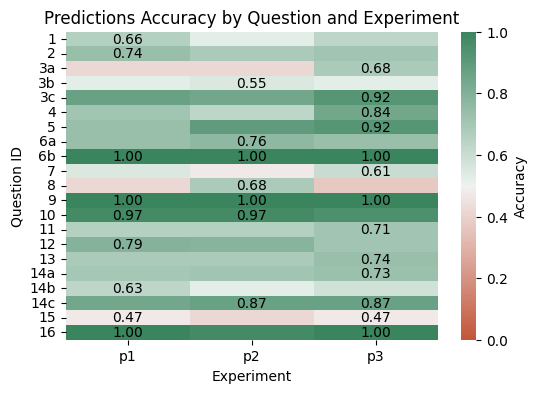

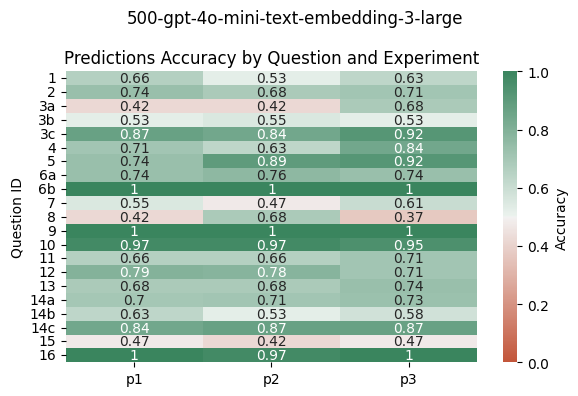

In [173]:
if os.path.exists(path + filename + '-p1.csv') and os.path.exists(path + filename + '-p2.csv') and os.path.exists(path + filename + '-p3.csv'):
    df1 = pd.read_csv(path + filename + '-p1.csv')
    df1['experiment'] = 'p1'
    df2 = pd.read_csv(path + filename + '-p2.csv')
    df2['experiment'] = 'p2'
    df3 = pd.read_csv(path + filename + '-p3.csv')
    df3['experiment'] = 'p3'
    
    # Combine the data
    df = pd.concat([df1, df2, df3])
    
    # Replace categorical 'YES'/'NO' with numeric 1/0
    df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)
    
    # Load human labels
    df_labels = pd.read_csv('./data_out/human_labels.csv', delimiter=';', dtype=int)
    df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
    df_labels['paper_id'] = df_labels['paper_id'].astype(int)
    df_labels['question_id'] = df_labels['question_id'].astype(int)
    df_labels['answer'] = df_labels['answer'].astype(int)
    
    # Merge predictions with true labels
    df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))
    
    # Add a 'result' column indicating whether the prediction matches the true label
    df_merged['result'] = np.where(
        df_merged['answer_pred'].isin([0, 1]),
        df_merged['answer_pred'] == df_merged['answer_true'],
        np.nan
    )
    df_merged.dropna(inplace=True)
    
    # Calculate accuracy by question and experiment
    accuracy_by_question_exp = df_merged.groupby(['question_id', 'experiment'])['result'].mean().reset_index()
    
    # Calculate the best accuracy for each question
    accuracy_by_question_exp['is_best'] = accuracy_by_question_exp.groupby('question_id')['result'].transform(
        lambda x: x == x.max()
    )

    # Pivot the data for heatmap
    pivot_accuracy = accuracy_by_question_exp.pivot(index='question_id', columns='experiment', values='result')
    pivot_is_best = accuracy_by_question_exp.pivot(index='question_id', columns='experiment', values='is_best')

    print("Sum of best values:", accuracy_by_question_exp.loc[accuracy_by_question_exp['is_best']].groupby('question_id')['result'].first().sum())

    # Heatmap with best values highlighted
    fig, ax1 = plt.subplots(figsize=(6, 4))
    cmap = sns.diverging_palette(20, 145, as_cmap=True)

    # Annotate best values
    def highlight_best(data, is_best):
        for i in range(data.shape[0]):  # Row indices
            for j in range(data.shape[1]):  # Column indices
                if is_best.iloc[i, j]:  # Check if it's the best
                    ax1.text(
                        j + 0.5, i + 0.5,  # Text position (center of the cell)
                        f"{data.iloc[i, j]:.2f}",  # Annotated value
                        ha='center', va='center',
                        color='black'
                    )

    # Draw heatmap
    sns.heatmap(
        pivot_accuracy,
        annot=False,  # Disable default annotations
        cmap=cmap,
        cbar_kws={'label': 'Accuracy'},
        vmin=0, vmax=1,
        ax=ax1
    )

    # Add highlights
    highlight_best(pivot_accuracy, pivot_is_best)

    # Configure plot
    ax1.set_title('Predictions Accuracy by Question and Experiment')
    ax1.set_xlabel('Experiment')
    ax1.set_ylabel('Question ID')
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

    if GROLTS_LABELS:
        ax1.set_yticklabels([
            '1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10',
            '11', '12', '13', '14a', '14b', '14c', '15', '16'
        ])

    # Plotting
    if GROUND_TRUTH_PLOT:
        fig = plt.figure(figsize=(11.69, 5))
        gs = GridSpec(1, 2, width_ratios=[2, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
    else:
        fig, ax1 = plt.subplots(figsize=(6, 4))
    
    # Heatmap for predictions accuracy by question and experiment
    pivot_accuracy = accuracy_by_question_exp.pivot(index='question_id', columns='experiment', values='result')
    g = sns.heatmap(
        pivot_accuracy,
        annot=True,
        cmap=sns.diverging_palette(20, 145, as_cmap=True),
        cbar_kws={'label': 'Accuracy'},
        vmin=0, vmax=1,
        ax=ax1
    )
    ax1.set_title('Predictions Accuracy by Question and Experiment')
    ax1.set_xlabel('')
    ax1.set_ylabel('Question ID')
    if GROLTS_LABELS:
        g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    
    if GROUND_TRUTH_PLOT:
        # Prepare the true labels data for comparison
        percent_true_by_question_lab = df_labels.groupby('question_id')['answer'].mean().reset_index()
    
        # Heatmap for ground truth mean accuracy by question
        g = sns.heatmap(
            percent_true_by_question_lab.set_index('question_id'),
            annot=True,
            cmap=sns.diverging_palette(0, 0, l=100, center="dark", as_cmap=True),
            cbar_kws={'label': 'Percentage True'},
            vmin=0, vmax=1,
            ax=ax2
        )
        ax2.set_title('Ground Truth Mean')
        ax2.set_xlabel('')
        ax2.set_ylabel('Question ID')
        if GROLTS_LABELS:
            g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
        ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
    
    # Final title and layout adjustment
    fig.suptitle(filename)
    fig.tight_layout()
    plt.savefig('../viz/questions-' + chunk_size + '-' + generator + '-' + embedder + '.pdf', bbox_inches='tight')
    plt.show()


# Context size comparison

In [174]:
if os.path.exists(path + '500-' + generator + '-' + embedder + experiment + '.csv') and os.path.exists(path + '1000-' + generator + '-' + embedder + experiment + '.csv') and os.path.exists(path + '2000-' + generator + '-' + embedder + experiment + '.csv'):
    df1 = pd.read_csv(path + '500-' + generator + '-' + embedder + experiment + '.csv')
    df1['experiment'] = '1500'
    df2 = pd.read_csv(path + '1000-' + generator + '-' + embedder + experiment + '.csv')
    df2['experiment'] = '5000'
    df3 = pd.read_csv(path + '2000-' + generator + '-' + embedder + experiment + '.csv')
    df3['experiment'] = '10000'
    
    # Combine the data
    df = pd.concat([df1, df2, df3])
    
    # Replace categorical 'YES'/'NO' with numeric 1/0
    df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)
    
    # Load human labels
    df_labels = pd.read_csv('./data_out/human_labels.csv', delimiter=';', dtype=int)
    df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
    df_labels['paper_id'] = df_labels['paper_id'].astype(int)
    df_labels['question_id'] = df_labels['question_id'].astype(int)
    df_labels['answer'] = df_labels['answer'].astype(int)
    
    # Merge predictions with true labels
    df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))
    
    # Add a 'result' column indicating whether the prediction matches the true label
    df_merged['result'] = np.where(
        df_merged['answer_pred'].isin([0, 1]),
        df_merged['answer_pred'] == df_merged['answer_true'],
        np.nan
    )
    df_merged.dropna(inplace=True)
    
    # Calculate accuracy by question and experiment
    accuracy_by_question_exp = df_merged.groupby(['question_id', 'experiment'])['result'].mean().reset_index()
    
    # Plotting
    if GROUND_TRUTH_PLOT:
        fig = plt.figure(figsize=(11.69, 5))
        gs = GridSpec(1, 2, width_ratios=[2, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
    else:
        fig, ax1 = plt.subplots(figsize=(6, 4))
    
    # Heatmap for predictions accuracy by question and experiment
    pivot_accuracy = accuracy_by_question_exp.pivot(index='question_id', columns='experiment', values='result')
    g = sns.heatmap(
        pivot_accuracy,
        annot=True,
        cmap=sns.diverging_palette(20, 145, as_cmap=True),
        cbar_kws={'label': 'Accuracy'},
        vmin=0, vmax=1,
        ax=ax1
    )
    ax1.set_title('Predictions Accuracy by Question and Experiment')
    ax1.set_xlabel('')
    ax1.set_ylabel('Question ID')
    if GROLTS_LABELS:
        g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
    
    if GROUND_TRUTH_PLOT:
        # Prepare the true labels data for comparison
        percent_true_by_question_lab = df_labels.groupby('question_id')['answer'].mean().reset_index()
    
        # Heatmap for ground truth mean accuracy by question
        g = sns.heatmap(
            percent_true_by_question_lab.set_index('question_id'),
            annot=True,
            cmap=sns.diverging_palette(0, 0, l=100, center="dark", as_cmap=True),
            cbar_kws={'label': 'Percentage True'},
            vmin=0, vmax=1,
            ax=ax2
        )
        ax2.set_title('Ground Truth Mean')
        ax2.set_xlabel('')
        ax2.set_ylabel('Question ID')
        if GROLTS_LABELS:
            g.set_yticklabels(['1', '2', '3a', '3b', '3c', '4', '5', '6a', '6b', '7', '8', '9', '10', '11', '12', '13', '14a', '14b', '14c', '15', '16']) 
        ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
    
    # Final title and layout adjustment
    fig.suptitle(filename)
    fig.tight_layout()
    plt.savefig('../viz/contexts-' + generator + '-' + embedder + experiment + '.pdf', bbox_inches='tight')
    plt.show()


In [32]:
import pandas as pd
import numpy as np

df = pd.read_csv("./data_out/500-microsoft-phi-4-text-embedding-3-large-p3.csv")
df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)

df_labels = pd.read_csv('./data_out/human_labels.csv', delimiter=';', dtype=int)
df_labels = df_labels.melt(id_vars=['paper_id'], var_name='question_id', value_name='answer')
df_labels['paper_id'] = df_labels['paper_id'].astype(int)
df_labels['question_id'] = df_labels['question_id'].astype(int)
df_labels['answer'] = df_labels['answer'].astype(int)

df_labels = df_labels[df_labels["question_id"] == 19]

df = df[df["question_id"] == 19]

# Merge predictions with true labels
df_merged = df.merge(df_labels, on=['paper_id', 'question_id'], suffixes=('_pred', '_true'))

# Add a 'result' column indicating whether the prediction matches the true label
df_merged['result'] = np.where(
    df_merged['answer_pred'].isin([0, 1]),
    df_merged['answer_pred'] == df_merged['answer_true'],
    np.nan
)

/var/folders/ls/wcyl7trn42jcdp0b2tp0mqqr0000gn/T/ipykernel_7013/1085881378.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(('YES', 'Yes', 'yes', 'NO', 'No', 'no'), (1, 1, 1, 0, 0, 0), inplace=True)


In [34]:
df_merged[df_merged["result"] == 0].to_csv("500-phi-4-3-large-p3-q19.csv")